# **Model Selection to estimate Agents**

For each station, find a good model to predict the individual pollutants.

## **Input Data**

Using the process defined in the [training data notebook](./4-training-and-test-sets.ipynb), initiate the datasets.

In [72]:
%load_ext autoreload
%autoreload 2

from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_squared_error

from sklearn.model_selection import train_test_split

from utils import *

datasets_folder = './datasets'
figsize = (20,4)
verbosity = 0

metrics = [root_mean_squared_error, r2_score, mean_absolute_error, mean_squared_error]

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[]


In [73]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [74]:
station_data = {}
station_dists = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station], station_dists[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


In [75]:
display(station_dists)

{'GIARDINI MARGHERITA': {'NO2': {'mean': 17.136602996327458,
   'std': 12.587616590341343},
  'O3': {'mean': 48.99323253026026, 'std': 37.846167292629794},
  'PM10': {'mean': 22.191091954022987, 'std': 14.34740358417706},
  'PM2.5': {'mean': 14.040932889100429, 'std': 11.592741566776404}},
 'PORTA SAN FELICE': {'C6H6': {'mean': 0.968151707217338,
   'std': 0.7318637341961725},
  'CO': {'mean': 0.5782450785309969, 'std': 0.309891655957885},
  'NO2': {'mean': 39.71247258825127, 'std': 19.295279052188466},
  'PM10': {'mean': 25.275375939849624, 'std': 15.307084342757124},
  'PM2.5': {'mean': 15.601595495072736, 'std': 11.83142061990551}},
 'VIA CHIARINI': {'NO2': {'mean': 17.895650152999963,
   'std': 13.344157597945486},
  'O3': {'mean': 44.30852219807513, 'std': 38.50506210669337},
  'PM10': {'mean': 22.202087286527515, 'std': 13.572458621794096}}}

We can inspect the hourly and daily features:

In [76]:
station_data['GIARDINI MARGHERITA']['NO2'].columns

Index(['Agent_value', 'Traffic_value', 'TAVG', 'PREC', 'RHAVG', 'RAD',
       'W_SCAL_INT', 'W_VEC_DIR', 'LEAFW', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_rbf_1', 'month_rbf_2', 'month_rbf_3', 'month_rbf_4',
       'month_rbf_5', 'month_rbf_6', 'month_rbf_7', 'month_rbf_8',
       'month_rbf_9', 'month_rbf_10', 'month_rbf_11', 'month_rbf_12'],
      dtype='object')

In [77]:
station_data['GIARDINI MARGHERITA']['PM2.5'].columns

Index(['Agent_value', 'Traffic_0-2', 'Traffic_3-5', 'Traffic_6-8',
       'Traffic_9-11', 'Traffic_12-14', 'Traffic_15-17', 'Traffic_18-20',
       'Traffic_21-0', 'TAVG', 'PREC', 'RHAVG', 'RAD', 'W_SCAL_INT',
       'W_VEC_DIR', 'LEAFW', 'TAVG_MAX', 'TAVG_MIN', 'RHAVG_MAX', 'RHAVG_MIN',
       'day_sin', 'day_cos', 'month_rbf_1', 'month_rbf_2', 'month_rbf_3',
       'month_rbf_4', 'month_rbf_5', 'month_rbf_6', 'month_rbf_7',
       'month_rbf_8', 'month_rbf_9', 'month_rbf_10', 'month_rbf_11',
       'month_rbf_12'],
      dtype='object')

As we can see for daily data we have the correct encoding of the hourly values for the traffic and the weather (like 'TAVG_MAX','TAVG_MIN', 'RHAVG_MAX', 'RHAVG_MIN') and the data encoding.

## **Training Data**

Our data covers 2019, ..., 2024. We decided to use 2024 as the test set.

In [78]:
train_split_date = datetime(2023,12,31,23)
RANDOM_STATE = 42

In [79]:
train_sets = {}
test_sets = {}

for station in stations:
    train_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        train_sets[station][agent] = {}
        test_sets[station][agent] = {}

        X_train, y_train, X_test, y_test = create_train_test(station_data[station][agent], train_split_date, y='Agent_value')

        train_sets[station][agent]['x'] = X_train
        train_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = X_test
        test_sets[station][agent]['y'] = y_test

In [80]:
train_sets['GIARDINI MARGHERITA']['NO2']['x'].head(1) # example

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,-1.088063,-1.801424,-0.137549,1.678544,-0.663642,-0.919936,0.883229,2.156313,0.0,1.0,...,0.000335,1.522998e-08,1.266417e-14,1.928750e-22,5.380186e-32,1.928750e-22,1.266417e-14,1.522998e-08,0.000335,0.135335


In [81]:
train_sets['GIARDINI MARGHERITA']['NO2']['y'].head(1)

,Agent_value
Date,
2019-01-02,0.624699


In [82]:
train_sets['GIARDINI MARGHERITA']['NO2']['y']

,Agent_value
Date,
2019-01-02 00:00:00,0.624699
2019-01-02 01:00:00,0.624699
2019-01-02 02:00:00,0.386367
2019-01-02 03:00:00,0.306923
2019-01-02 05:00:00,1.021919
...,...
2023-12-31 19:00:00,0.148036
2023-12-31 20:00:00,-0.646404
2023-12-31 21:00:00,-0.884735


In [83]:
def merge_train_sets(train_sets):
    merged_train = {}
    for station in train_sets.keys():
        for agent in train_sets[station].keys():
            if agent not in merged_train:
                merged_train[agent] = {}
                merged_train[agent]['x'] = pd.DataFrame()
                merged_train[agent]['y'] = pd.DataFrame()
            merged_train[agent]['x'] = pd.concat([merged_train[agent]['x'], train_sets[station][agent]['x']], axis=0)
            merged_train[agent]['y'] = pd.concat([merged_train[agent]['y'], train_sets[station][agent]['y']], axis=0)
    return merged_train
merged_train_sets = merge_train_sets(train_sets)
for agent in merged_train_sets.keys():
    print(f'Agent {agent} train set shape: \t{merged_train_sets[agent]["x"].shape}, {merged_train_sets[agent]["y"].shape}')

Agent NO2 train set shape: 	(128545, 24), (128545, 1)
Agent O3 train set shape: 	(85779, 24), (85779, 1)
Agent PM10 train set shape: 	(5280, 33), (5280, 1)
Agent PM2.5 train set shape: 	(3517, 33), (3517, 1)
Agent C6H6 train set shape: 	(40757, 24), (40757, 1)
Agent CO train set shape: 	(43012, 24), (43012, 1)


## **Models**

We define different model architectures to try evaluate the pollutants.

A good result would be a certain architecture resulting in the best results for certain agents across all the stations, or even across all the agents.

Certain models will use sequences as input, for example LSTMs and Convolutional Networks.

The clear problem of this approach is the fact that it is really hard to find, while testing, a model able to work well with all the agents after being tested on a small subset of them. We will be able to check if the model actually work nice on other agents, but it will most likely work very well just with the agents it has been tested on.

The following models have been tested and produced good results. We will now test all of them across all the stations and agents.

### **Hourly Models**

In [84]:
hour_models = {} # contains tuples: (ModelGenerator, model_params:dict, training_params:dict|None, uses_sequences:bool)

#### Random Forest Regressor

##### *Models*

In [85]:
rfr_params = {
    'n_estimators':300,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

hour_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

In [86]:
rfr2_params = {
    'n_estimators':500,
    'max_depth':15,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

hour_models['Random Forest Regressor 2'] = (RandomForestRegressor, rfr2_params, None, False)

##### *Testing*

In [87]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_rfr = 'Random Forest Regressor'

In [88]:
rfr_model = RandomForestRegressor(**hour_models[selected_rfr][1])
rfr_model.fit(merged_train_sets[agent]['x'], merged_train_sets[agent]['y'].to_numpy().ravel())
rfr_pred = rfr_model.predict(test_sets[station][agent]['x'])
rfr_pred_df = pd.DataFrame(rfr_pred, index=test_sets[station][agent]['y'].index)

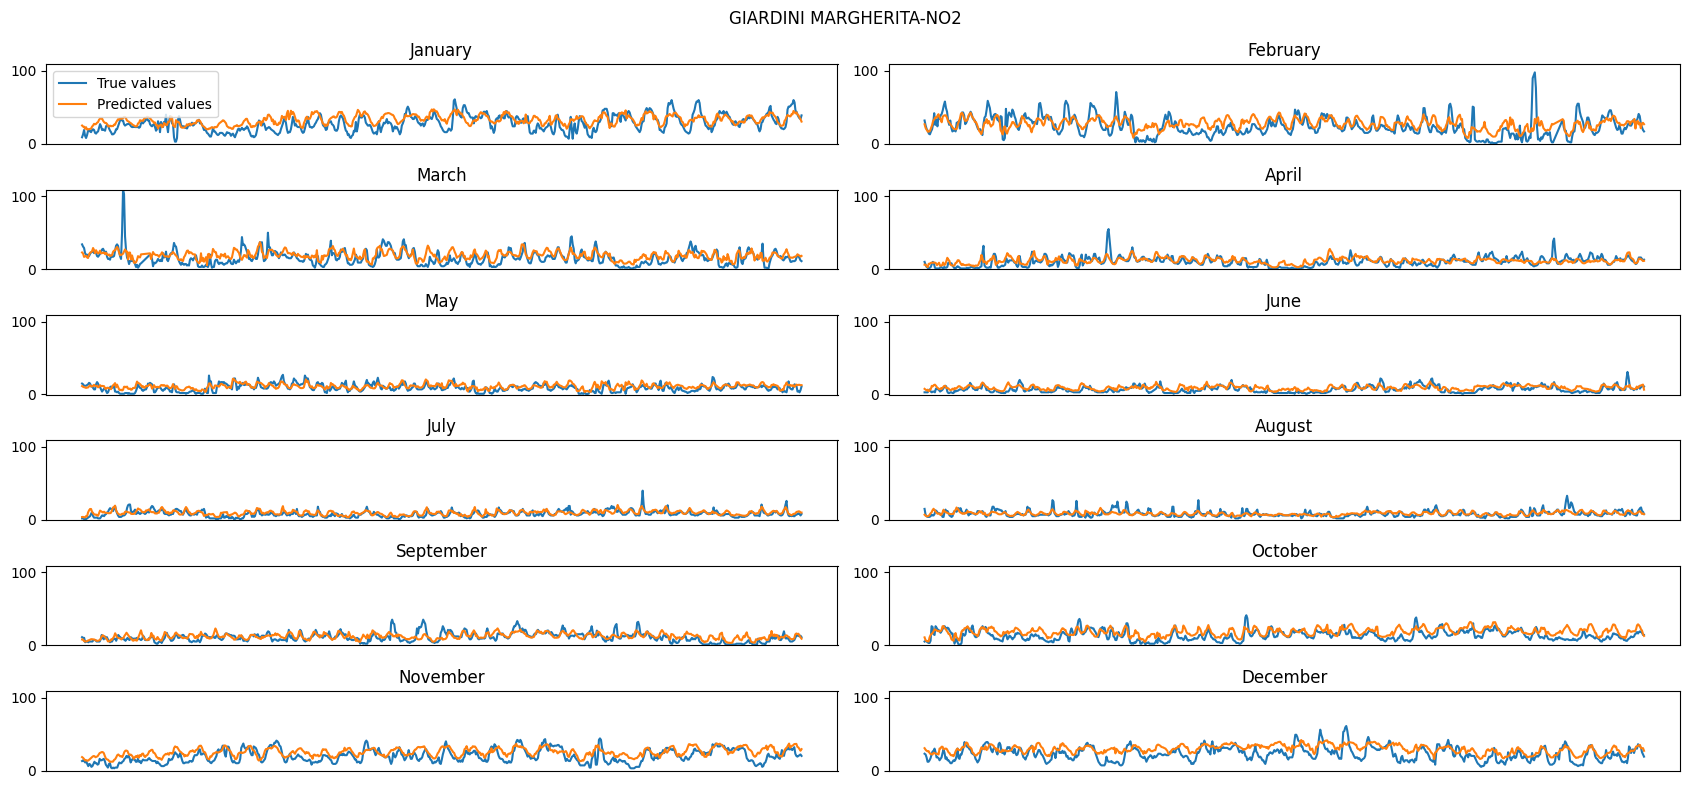

root_mean_squared_error: 0.5931742130310139
r2_score: 0.5002688307788383
mean_absolute_error: 0.44014064484161003
mean_squared_error: 0.3518556470049627


In [89]:
plot_months_predictions(test_sets[station][agent]['y'], rfr_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### XGBoost

##### *Models*

In [90]:
xgbr_params = {
    'objective': "reg:absoluteerror",
    'n_estimators': 180,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE
}

hour_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

In [91]:
xgbr2_params = {
    'objective': "reg:squarederror",
    'n_estimators': 250,
    'max_depth': 10,
    'learning_rate': 0.1,
    'subsample': 0.75,
    'random_state': RANDOM_STATE
}

hour_models['XGB Regressor 2'] = (xgb.XGBRegressor, xgbr2_params, None, False)

##### *Testing*

In [92]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_xgbr = 'XGB Regressor'

In [93]:
validation_ratio = 0.1

X_train, y_train = merged_train_sets[agent]['x'], merged_train_sets[agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

xgbr_model = xgb.XGBRegressor(**hour_models[selected_xgbr][1])
xgbr_model.fit(X_train, y_train, eval_set=validation_data)
xgbr_pred = xgbr_model.predict(test_sets[station][agent]['x'])
xgbr_pred_df = pd.DataFrame(xgbr_pred, index=test_sets[station][agent]['y'].index)

[0]	validation_0-mae:0.77425
[1]	validation_0-mae:0.74630
[2]	validation_0-mae:0.72068
[3]	validation_0-mae:0.69754
[4]	validation_0-mae:0.67633
[5]	validation_0-mae:0.65744
[6]	validation_0-mae:0.64020
[7]	validation_0-mae:0.62423
[8]	validation_0-mae:0.60941
[9]	validation_0-mae:0.59650
[10]	validation_0-mae:0.58491
[11]	validation_0-mae:0.57432
[12]	validation_0-mae:0.56470
[13]	validation_0-mae:0.55622
[14]	validation_0-mae:0.54827
[15]	validation_0-mae:0.54119
[16]	validation_0-mae:0.53398
[17]	validation_0-mae:0.52788
[18]	validation_0-mae:0.52237
[19]	validation_0-mae:0.51716
[20]	validation_0-mae:0.51232
[21]	validation_0-mae:0.50797
[22]	validation_0-mae:0.50424
[23]	validation_0-mae:0.50042
[24]	validation_0-mae:0.49698
[25]	validation_0-mae:0.49394
[26]	validation_0-mae:0.49061
[27]	validation_0-mae:0.48792
[28]	validation_0-mae:0.48569
[29]	validation_0-mae:0.48313
[30]	validation_0-mae:0.48124
[31]	validation_0-mae:0.47907
[32]	validation_0-mae:0.47735
[33]	validation_0-ma

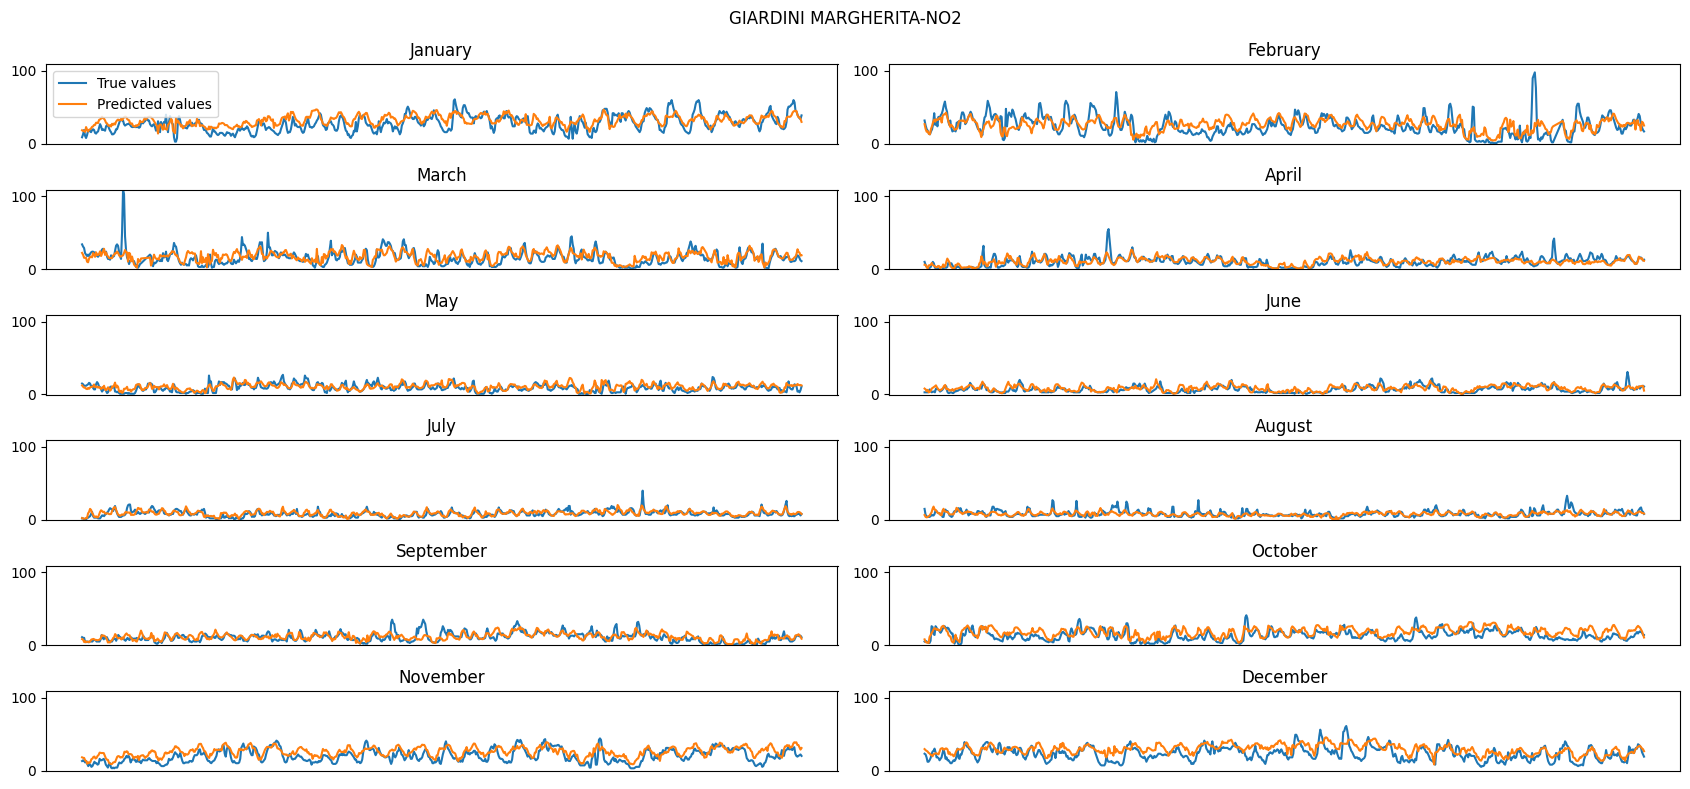

root_mean_squared_error: 0.5792019574988372
r2_score: 0.5235339570883881
mean_absolute_error: 0.41772578156123685
mean_squared_error: 0.33547490757048476


In [94]:
plot_months_predictions(test_sets[station][agent]['y'], xgbr_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### LSTM

##### *Models*

In [177]:
lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error',
    'use_mask': False # fill nan using bfill()
}

lstm_train_params = {
    'epochs':20,
    'batch_size':64,
}

hour_models['LSTM'] = (build_lstm_model, lstm_params, lstm_train_params, True)

In [96]:
masked_lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error',
    'use_mask': True # apply a mask to nan, instead of filling
}

masked_lstm_train_params = {
    'epochs':50,
    'batch_size':32,
}

hour_models['LSTM-masked'] = (build_lstm_model, masked_lstm_params, masked_lstm_train_params, True)

In [97]:
lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': False
}

lstm2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM 2'] = (build_lstm_model, lstm2_params, lstm2_train_params, True)


In [98]:
masked_lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': True
}

masked_lstm2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM 2-masked'] = (build_lstm_model, masked_lstm2_params, masked_lstm2_train_params, True)


##### *Testing*

In [178]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_lstm = 'LSTM'

In [179]:
validation_ratio = 0.1
selected_lstm_model = hour_models[selected_lstm]

ts = selected_lstm_model[1]['time_steps']
# lstm_X_train, lstm_y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)

lstm_X_train, lstm_y_train = None, None
for station in stations:
    if agent in train_sets[station].keys():
        X_train, y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)
        if lstm_X_train is None:
            lstm_X_train = X_train
            lstm_y_train = y_train
        else:
            lstm_X_train = np.concatenate((lstm_X_train, X_train), axis=0)
            lstm_y_train = np.concatenate((lstm_y_train, y_train), axis=0)

lstm_X_test = pd.concat([train_sets[station][agent]['x'].iloc[-ts+1:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
lstm_X_test, lstm_y_test = create_sequences(lstm_X_test, test_sets[station][agent]['y'], ts, use_mask=False)

lstm_X_train, lstm_X_val, lstm_y_train, lstm_y_val = train_test_split(lstm_X_train, lstm_y_train, test_size=validation_ratio, random_state=42, shuffle=True)

In [180]:
lstm_X_train, lstm_X_val, lstm_y_train, lstm_y_val = train_test_split(lstm_X_train, lstm_y_train, test_size=validation_ratio, random_state=42, shuffle=True)

Epoch 1/20
1627/1627 [==============================] - 17s 9ms/step - loss: 0.4890 - val_loss: 0.4736
Epoch 2/20
1627/1627 [==============================] - 13s 8ms/step - loss: 0.4705 - val_loss: 0.4670
Epoch 3/20
1627/1627 [==============================] - 13s 8ms/step - loss: 0.4625 - val_loss: 0.4641
Epoch 4/20
1627/1627 [==============================] - 14s 9ms/step - loss: 0.4562 - val_loss: 0.4603
Epoch 5/20
1627/1627 [==============================] - 14s 9ms/step - loss: 0.4502 - val_loss: 0.4561
Epoch 6/20
1627/1627 [==============================] - 14s 9ms/step - loss: 0.4453 - val_loss: 0.4510
Epoch 7/20
1627/1627 [==============================] - 13s 8ms/step - loss: 0.4406 - val_loss: 0.4478
Epoch 8/20
1627/1627 [==============================] - 14s 9ms/step - loss: 0.4363 - val_loss: 0.4475
Epoch 9/20
1627/1627 [==============================] - 14s 8ms/step - loss: 0.4320 - val_loss: 0.4445
Epoch 10/20
1627/1627 [==============================] - 14s 9ms/step - l

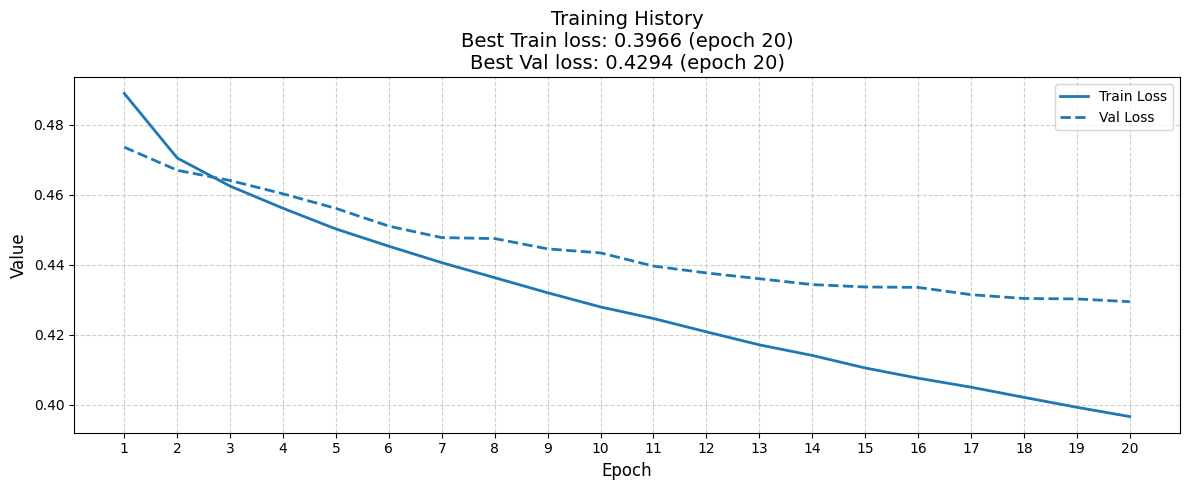

273/273 [==============================] - 3s 4ms/step


In [181]:
selected_lstm_model = hour_models[selected_lstm]
tf.keras.backend.clear_session()  # Reset TensorFlow state
set_random_seed(42) 
lstm_model = selected_lstm_model[0](**selected_lstm_model[1])
lstm_history = lstm_model.fit(
    lstm_X_train,
    lstm_y_train,
    validation_data=(lstm_X_val, lstm_y_val),
    **selected_lstm_model[2],
)
plot_history(lstm_history)
lstm_pred = lstm_model.predict(lstm_X_test)
lstm_pred_df = pd.DataFrame(lstm_pred, index=lstm_y_test.index)

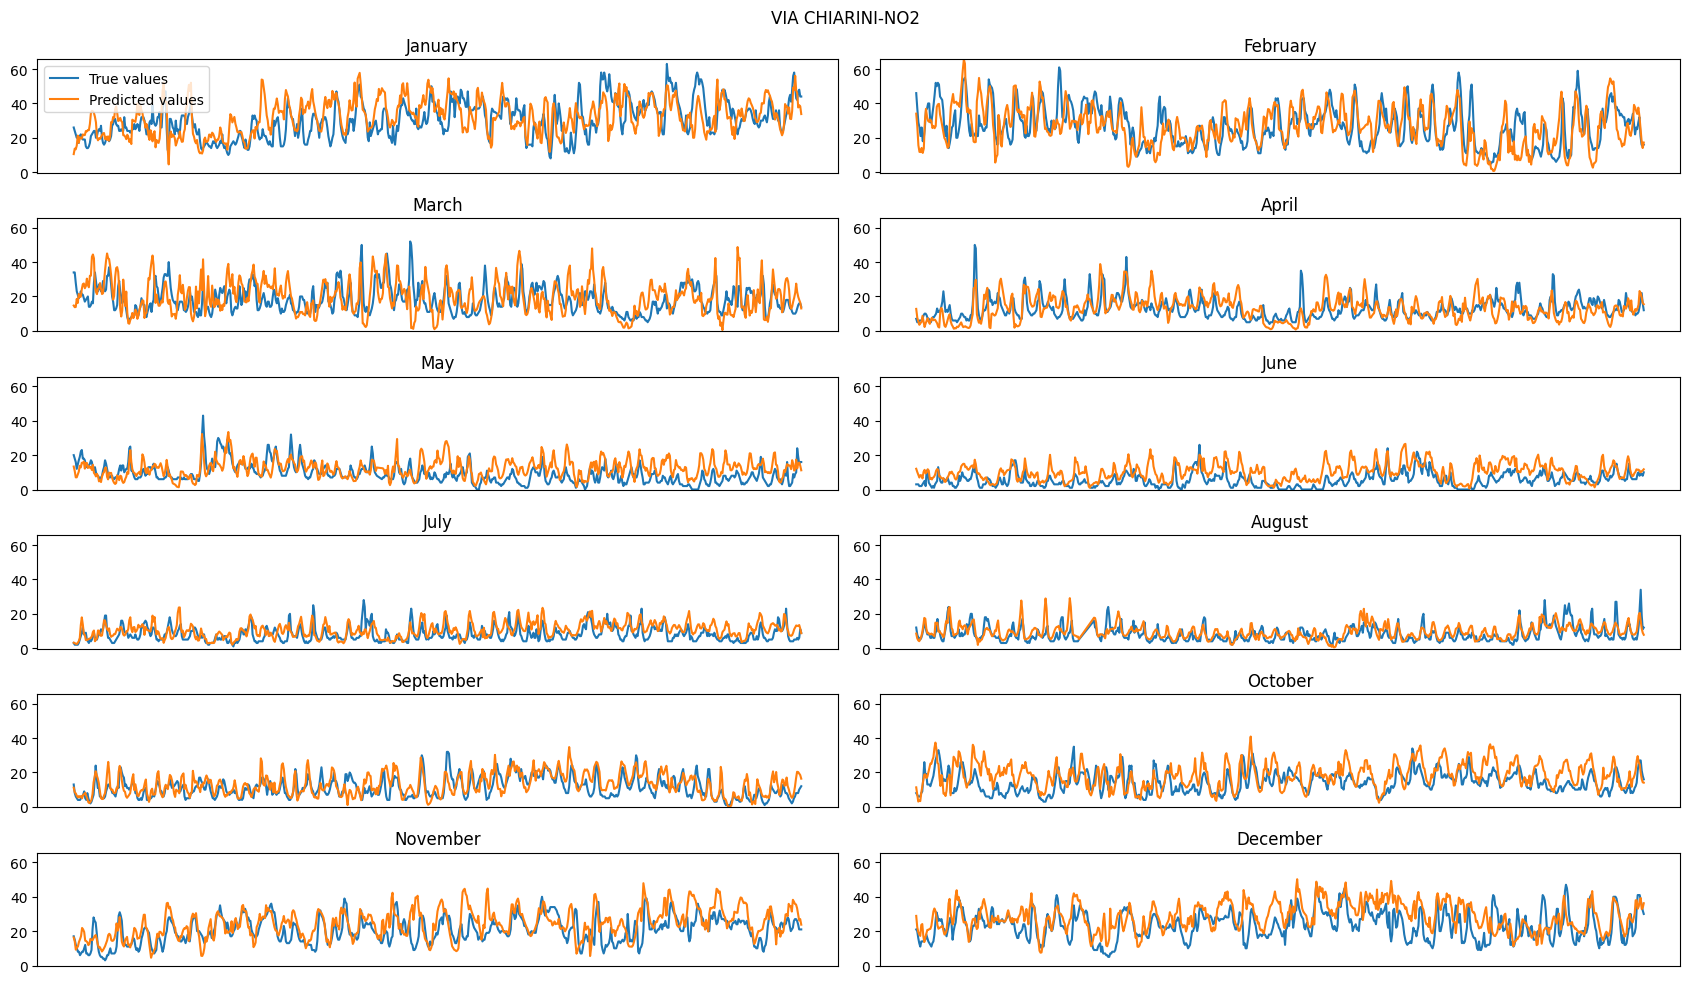

root_mean_squared_error: 0.5812128124064033
r2_score: 0.4522213124454678
mean_absolute_error: 0.44116435379653657
mean_squared_error: 0.3378083333053609


In [104]:
plot_months_predictions(lstm_y_test, lstm_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}', figsize=(17,10))

#### Feed Forward Neural Network

##### *Models*

In [105]:
ffnn_params = {
    'input_size': n_hour_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN'] = (build_ffnn_model, ffnn_params, ffnn_train_params, False)

In [106]:
bn_ffnn_params = {
    'input_size': n_hour_features,
    'neurons': [1024, 512, 256, 128],
    'batch_norm': True,
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

bn_ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN BatchNorm'] = (build_ffnn_model, bn_ffnn_params, bn_ffnn_train_params, False)

In [107]:
ffnn2_params = {
    'input_size': n_hour_features,
    'neurons': [512, 256, 128],
    'dropout': 0.3,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn2_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN 2'] = (build_ffnn_model, ffnn2_params, ffnn2_train_params, False)

##### *Testing*

In [108]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_ffnn = 'Feed Forward NN'

In [109]:
tf.keras.backend.clear_session()  
set_random_seed(42) 
ffnn_model = build_ffnn_model(**hour_models[selected_ffnn][1])
ffnn_model.fit(
    merged_train_sets[agent]['x'], 
    merged_train_sets[agent]['y'], 
    **hour_models[selected_ffnn][2]
    )
ffnn_pred = ffnn_model.predict(test_sets[station][agent]['x'])
ffnn_pred_df = pd.DataFrame(ffnn_pred, index=test_sets[station][agent]['y'].index)

Epoch 1/10
4018/4018 [==============================] - 15s 4ms/step - loss: 0.5989
Epoch 2/10
4018/4018 [==============================] - 15s 4ms/step - loss: 0.6029
Epoch 3/10
4018/4018 [==============================] - 15s 4ms/step - loss: 0.6167
Epoch 4/10
4018/4018 [==============================] - 15s 4ms/step - loss: 0.6043
Epoch 5/10
4018/4018 [==============================] - 15s 4ms/step - loss: 0.6130
Epoch 6/10
4018/4018 [==============================] - 15s 4ms/step - loss: 0.6263
Epoch 7/10
4018/4018 [==============================] - 15s 4ms/step - loss: 0.6326
Epoch 8/10
4018/4018 [==============================] - 15s 4ms/step - loss: 0.6755
Epoch 9/10
4018/4018 [==============================] - 15s 4ms/step - loss: 0.6441
Epoch 10/10
274/274 [==============================] - 0s 1ms/step


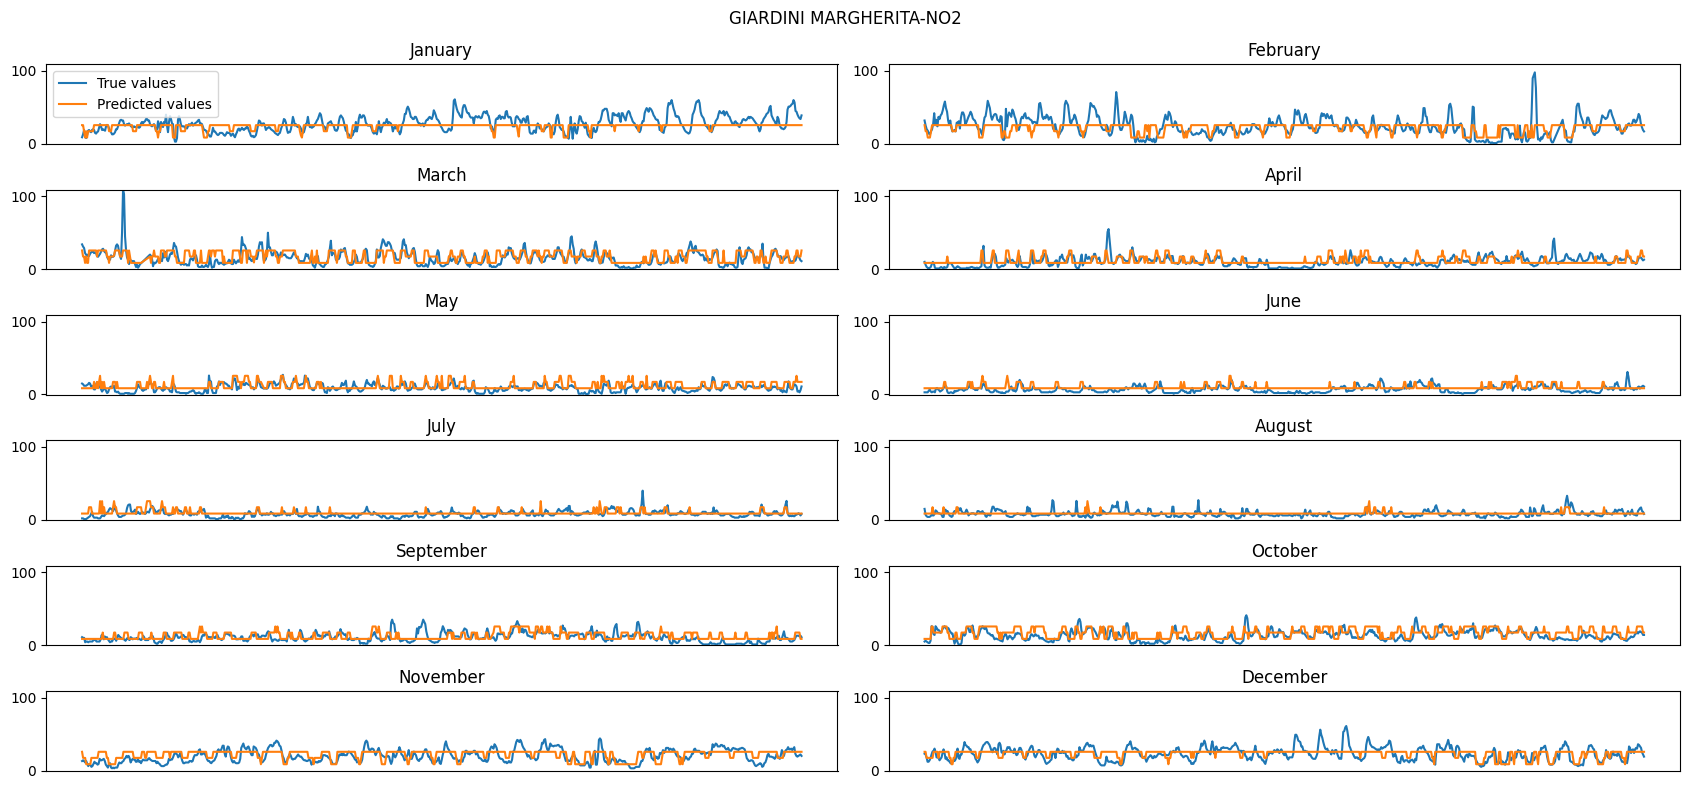

root_mean_squared_error: 0.6271955363266232
r2_score: 0.44130108195273166
mean_absolute_error: 0.46079728358335004
mean_squared_error: 0.39337424078804045


In [110]:
plot_months_predictions(test_sets[station][agent]['y'], ffnn_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### Conv1d

##### *Models*

In [111]:
conv_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': 64,
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

hour_models['Conv1D'] = (build_conv_model, conv_params, conv_train_params, True)

In [112]:
conv2_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv2_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

hour_models['Conv1D 2'] = (build_conv_model, conv2_params, conv2_train_params, True)

In [113]:
conv3_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv3_train_params = {
    'epochs': 20,
    'batch_size': 32,
}

hour_models['Conv1D 3'] = (build_conv_model, conv3_params, conv3_train_params, True)

##### *Testing*

In [114]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_conv = 'Conv1D'

In [115]:
validation_ratio = 0.1
selected_conv_model = hour_models[selected_conv]

ts = selected_conv_model[1]['time_steps']
# lstm_X_train, lstm_y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)

conv_X_train, conv_y_train = None, None
for station in stations:
    if agent in train_sets[station].keys():
        X_train, y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)
        if conv_X_train is None:
            conv_X_train = X_train
            conv_y_train = y_train
        else:
            conv_X_train = np.concatenate((conv_X_train, X_train), axis=0)
            conv_y_train = np.concatenate((conv_y_train, y_train), axis=0)

conv_X_test = pd.concat([train_sets[station][agent]['x'].iloc[-ts+1:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
conv_X_test, conv_y_test = create_sequences(conv_X_test, test_sets[station][agent]['y'], ts, use_mask=False)

conv_X_train, conv_X_val, conv_y_train, conv_y_val = train_test_split(conv_X_train, conv_y_train, test_size=validation_ratio, random_state=42, shuffle=True)

In [116]:
tf.keras.backend.clear_session()  
set_random_seed(42) 
conv_model = build_conv_model(**hour_models[selected_conv][1])
conv_model.fit(
    conv_X_train, 
    conv_y_train, 
    **hour_models[selected_conv][2])
conv_pred = conv_model.predict(conv_X_test)
conv_pred_df = pd.DataFrame(conv_pred, index=conv_y_test.index)

Epoch 1/10
1808/1808 [==============================] - 2s 1ms/step - loss: 0.4933
Epoch 2/10
1808/1808 [==============================] - 2s 1ms/step - loss: 0.4731
Epoch 3/10
1808/1808 [==============================] - 2s 1ms/step - loss: 0.4646
Epoch 4/10
1808/1808 [==============================] - 2s 1ms/step - loss: 0.4577
Epoch 5/10
1808/1808 [==============================] - 2s 1ms/step - loss: 0.4527
Epoch 6/10
1808/1808 [==============================] - 2s 1ms/step - loss: 0.4484
Epoch 7/10
1808/1808 [==============================] - 2s 1ms/step - loss: 0.4447
Epoch 8/10
1808/1808 [==============================] - 2s 1ms/step - loss: 0.4415
Epoch 9/10
1808/1808 [==============================] - 2s 1ms/step - loss: 0.4392
Epoch 10/10
273/273 [==============================] - 0s 632us/step


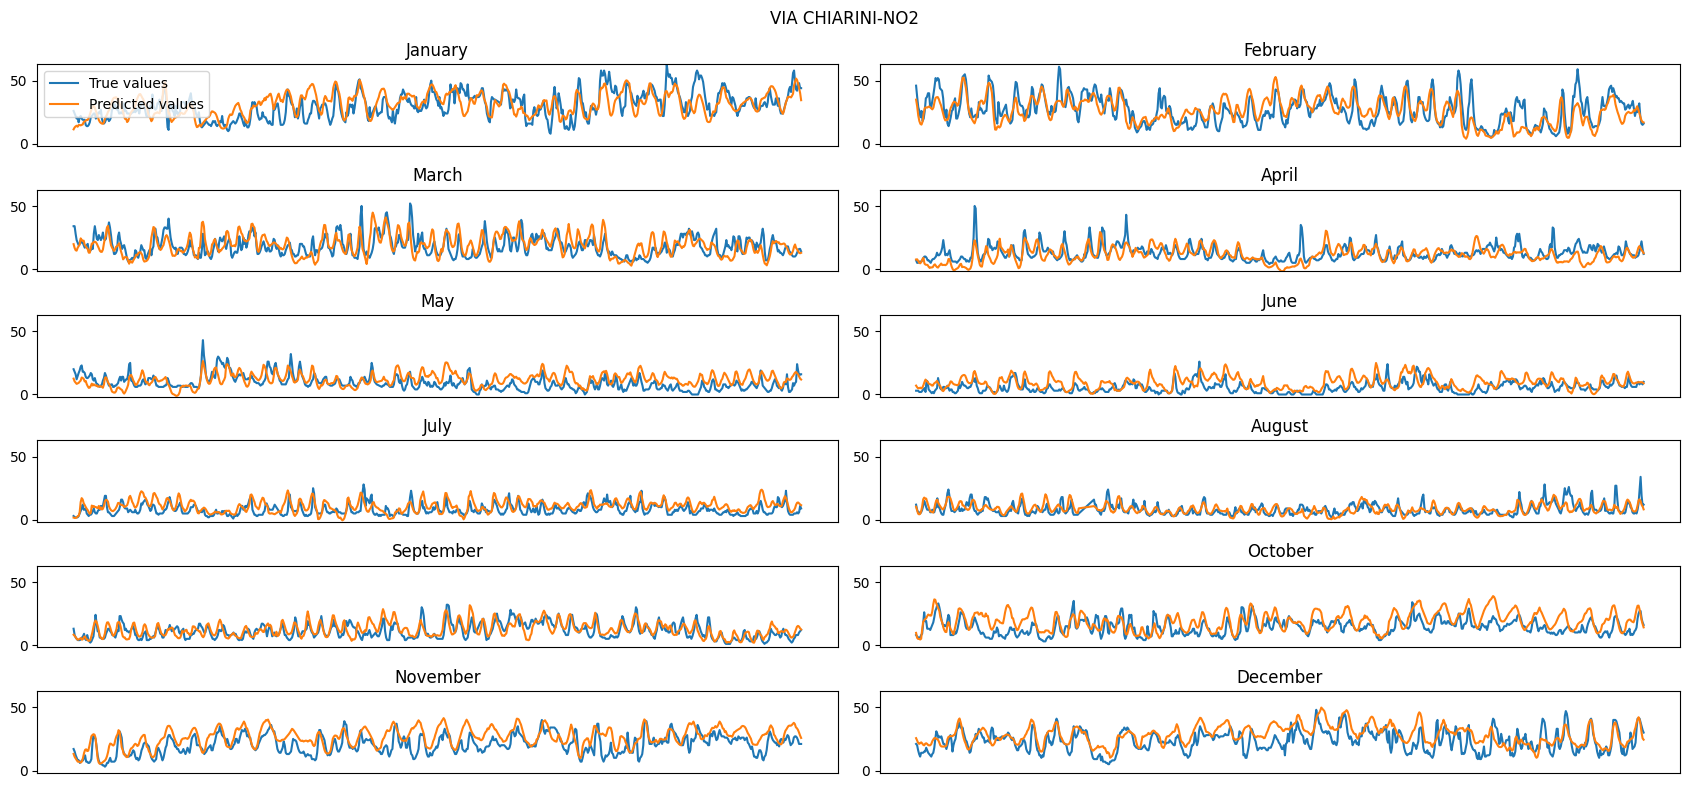

root_mean_squared_error: 0.530602869991747
r2_score: 0.5434651223394777
mean_absolute_error: 0.41036512393862046
mean_squared_error: 0.2815394056434788


In [117]:
plot_months_predictions(test_sets[station][agent]['y'], conv_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

### **Daily Models**

In [118]:
daily_models = {} # contains tuples: (ModelClass, model_params:dict, training_params:dict, uses_sequences:bool|dict)

#### Random Forest Regressor

##### *Models*

In [119]:
rfr_params = {
    'n_estimators':100,
    'max_depth':10,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

daily_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

In [120]:
rfr2_params = {
    'n_estimators':150,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

daily_models['Random Forest Regressor 2'] = (RandomForestRegressor, rfr2_params, None, False)

##### *Testing*

In [121]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_rfr = 'Random Forest Regressor'

In [122]:
rfr_daily_model = RandomForestRegressor(**daily_models[selected_daily_rfr][1])
rfr_daily_model.fit(merged_train_sets[agent]['x'], merged_train_sets[agent]['y'].to_numpy().ravel())
rfr_daily_pred = rfr_daily_model.predict(test_sets[station][agent]['x'])
rfr_daily_pred_df = pd.DataFrame(rfr_daily_pred, index=test_sets[station][agent]['y'].index)

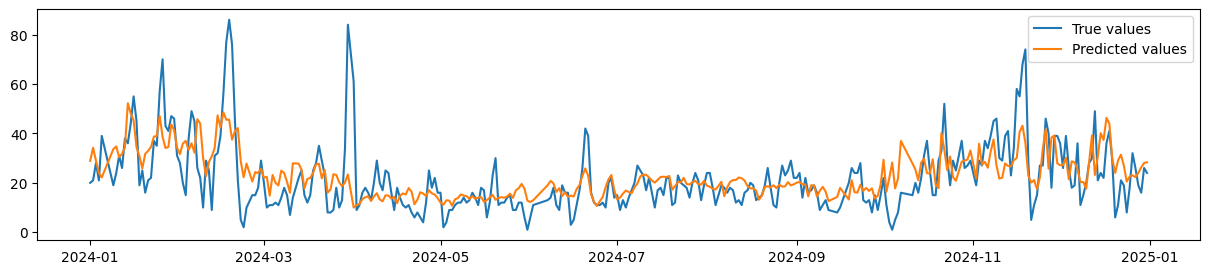

root_mean_squared_error: 0.7344808860714139
r2_score: 0.40313363023018123
mean_absolute_error: 0.5206811429026739
mean_squared_error: 0.5394621720042493


In [123]:
plot_year_predictions(test_sets[station][agent]['y'], rfr_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### XGBoost Regressor

##### *Models*

In [124]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

daily_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

In [ ]:
xgbr2_params = {
    'objective': "reg:squarederror",
    'n_estimators': 150,
    'max_depth': 10,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

daily_models['XGB Regressor 2'] = (xgb.XGBRegressor, xgbr2_params, None, False)

##### *Testing*

In [126]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_xgbr = 'XGB Regressor'

In [127]:
validation_ratio = 0.1

X_train, y_train = merged_train_sets[agent]['x'], merged_train_sets[agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

xgbr_daily_model = xgb.XGBRegressor(**hour_models[selected_daily_xgbr][1])
xgbr_daily_model.fit(X_train, y_train, eval_set=validation_data)
xgbr_daily_pred = xgbr_daily_model.predict(test_sets[station][agent]['x'])
xgbr_daily_pred_df = pd.DataFrame(xgbr_daily_pred, index=test_sets[station][agent]['y'].index)

[0]	validation_0-mae:0.63169
[1]	validation_0-mae:0.61081
[2]	validation_0-mae:0.59312
[3]	validation_0-mae:0.57613
[4]	validation_0-mae:0.56251
[5]	validation_0-mae:0.55140
[6]	validation_0-mae:0.53918
[7]	validation_0-mae:0.52663
[8]	validation_0-mae:0.51535
[9]	validation_0-mae:0.50587
[10]	validation_0-mae:0.49765
[11]	validation_0-mae:0.48962
[12]	validation_0-mae:0.48230
[13]	validation_0-mae:0.47491
[14]	validation_0-mae:0.46696
[15]	validation_0-mae:0.45996
[16]	validation_0-mae:0.45420
[17]	validation_0-mae:0.44889
[18]	validation_0-mae:0.44368
[19]	validation_0-mae:0.43819
[20]	validation_0-mae:0.43380
[21]	validation_0-mae:0.43111
[22]	validation_0-mae:0.42694
[23]	validation_0-mae:0.42290
[24]	validation_0-mae:0.41966
[25]	validation_0-mae:0.41639
[26]	validation_0-mae:0.41359
[27]	validation_0-mae:0.41005
[28]	validation_0-mae:0.40727
[29]	validation_0-mae:0.40481
[30]	validation_0-mae:0.40202
[31]	validation_0-mae:0.40080
[32]	validation_0-mae:0.39846
[33]	validation_0-ma

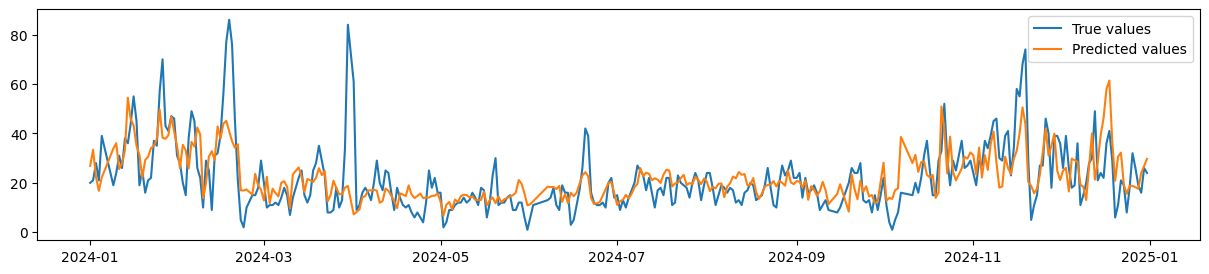

root_mean_squared_error: 0.723245392933771
r2_score: 0.4212547167801258
mean_absolute_error: 0.5021734649775128
mean_squared_error: 0.5230838983999248


In [128]:
plot_year_predictions(test_sets[station][agent]['y'], xgbr_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### Feed Forward Neural Network

##### *Models*

In [129]:
ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

daily_models['Feed Forward NN'] = (build_ffnn_model, ffnn_daily_params, ffnn_daily_train_params, False)

In [130]:
bn_ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'batch_norm': True,
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

bn_ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

daily_models['Feed Forward NN BatchNorm'] = (build_ffnn_model, bn_ffnn_daily_params, bn_ffnn_daily_train_params, False)

##### *Testing*

In [131]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_ffnn = 'Feed Forward NN'

In [132]:
tf.keras.backend.clear_session()  
set_random_seed(42) 
ffnn_daily_model = build_ffnn_model(**daily_models[selected_daily_ffnn][1])
ffnn_daily_model.fit(
    merged_train_sets[agent]['x'], 
    merged_train_sets[agent]['y'], 
    **daily_models[selected_daily_ffnn][2]
    )
ffnn_daily_pred = ffnn_daily_model.predict(test_sets[station][agent]['x'])
ffnn_daily_pred_df = pd.DataFrame(ffnn_daily_pred, index=test_sets[station][agent]['y'].index)

Epoch 1/20
165/165 [==============================] - 1s 3ms/step - loss: 0.5622
Epoch 2/20
165/165 [==============================] - 1s 3ms/step - loss: 0.5098
Epoch 3/20
165/165 [==============================] - 1s 3ms/step - loss: 0.4865
Epoch 4/20
165/165 [==============================] - 1s 3ms/step - loss: 0.4696
Epoch 5/20
165/165 [==============================] - 1s 3ms/step - loss: 0.4572
Epoch 6/20
165/165 [==============================] - 1s 3ms/step - loss: 0.4476
Epoch 7/20
165/165 [==============================] - 1s 3ms/step - loss: 0.4343
Epoch 8/20
165/165 [==============================] - 1s 4ms/step - loss: 0.4312
Epoch 9/20
165/165 [==============================] - 1s 3ms/step - loss: 0.4170
Epoch 10/20
165/165 [==============================] - 1s 3ms/step - loss: 0.4030
Epoch 11/20
165/165 [==============================] - 1s 3ms/step - loss: 0.3970
Epoch 12/20
165/165 [==============================] - 1s 3ms/step - loss: 0.3957
Epoch 13/20
165/165 [====

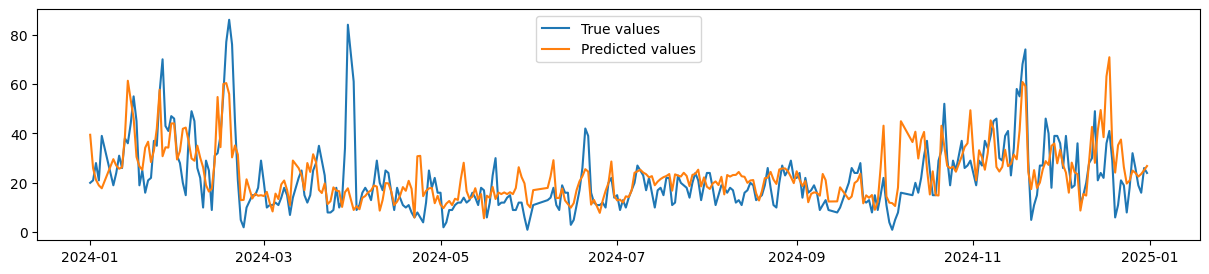

root_mean_squared_error: 0.7659614253076031
r2_score: 0.3508726467754125
mean_absolute_error: 0.534760823862012
mean_squared_error: 0.586696905059255


In [133]:
plot_year_predictions(test_sets[station][agent]['y'], ffnn_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### LSTM

In order to use LSTMs, we need to have sequences/time steps. For the other models, we aggregated the hourly data into a single day, but we could try to go back to hourly inputs aggregated in sequences of 24 hours.

The tests results were not convincing enough to keep experimentating.

## **Agents Evaluations**

### Hourly Models

In [134]:
hour_results = train_models_1_per_agent(
    hour_models, train_sets, merged_train_sets, test_sets, metrics,
    to_execute={
        'agents':'all',
        'stations':'all',
        'models':'all',
    },
    ignore={
        'stations':[],
        'agents':['PM10','PM2.5'],
        'models':[]
        },
    random_state=RANDOM_STATE,
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['NO2', 'O3', 'C6H6', 'CO']
models: ['Random Forest Regressor', 'Random Forest Regressor 2', 'XGB Regressor', 'XGB Regressor 2', 'LSTM', 'LSTM-masked', 'LSTM 2', 'LSTM 2-masked', 'Feed Forward NN', 'Feed Forward NN BatchNorm', 'Feed Forward NN 2', 'Conv1D', 'Conv1D 2', 'Conv1D 3']
Agent NO2
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> LSTM model
> LSTM-masked model
> LSTM 2 model
> LSTM 2-masked model
> Feed Forward NN model
> Feed Forward NN BatchNorm model
> Feed Forward NN 2 model
> Conv1D model
> Conv1D 2 model
> Conv1D 3 model
Agent O3
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> LSTM model
> LSTM-masked model
> LSTM 2 model
> LSTM 2-masked model
> Feed Forward NN model
> Feed Forward NN BatchNorm model
> Feed Forward NN 2 model
> Conv1D model
> Conv1D 

Since that we evaluated per-station, we need to compute the overall metric of each model across the stations. To do so, we simply apply the inverse formula of the metric and then normalize across all the dataset.\
*We could also put together the predictions and compute the metric, or directly evaluate per agent*.

In [165]:
hour_extracted_data = extract_model_scores(hour_results, test_sets)
hour_extracted_data_df = extracted_scores_to_dataframe(hour_extracted_data)

In [166]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(hour_extracted_data_df.sort_values(by=['Agent','root_mean_squared_error']))

,Agent,Model,root_mean_squared_error,mean_absolute_error,mean_squared_error
40,C6H6,Conv1D 2,0.566070,0.355883,0.320435
39,C6H6,Conv1D,0.567718,0.354768,0.322304
32,C6H6,LSTM,0.570564,0.347328,0.325544
41,C6H6,Conv1D 3,0.585756,0.366531,0.343110
30,C6H6,XGB Regressor,0.593932,0.362918,0.352755
28,C6H6,Random Forest Regressor,0.594912,0.377433,0.353921
29,C6H6,Random Forest Regressor 2,0.595330,0.377656,0.354418
34,C6H6,LSTM 2,0.598238,0.377063,0.357888
33,C6H6,LSTM-masked,0.622386,0.394322,0.387365
31,C6H6,XGB Regressor 2,0.622836,0.397652,0.387925


And we can display the best model for each station-agent

In [149]:
display(hour_extracted_data_df.loc[hour_extracted_data_df.groupby(by=['Agent'])['root_mean_squared_error'].idxmin()])

,Agent,Model,root_mean_squared_error,mean_absolute_error,mean_squared_error
40,C6H6,Conv1D 2,0.566070,0.355883,0.320435
46,CO,LSTM,0.651562,0.509523,0.424533
4,NO2,LSTM,0.682500,0.534704,0.500349
18,O3,LSTM,0.362456,0.271118,0.132266


### Daily Models

In [167]:
daily_results = train_models_1_per_agent(
    daily_models, train_sets, merged_train_sets, test_sets, metrics,
    to_execute={
        'agents':['PM10','PM2.5'],
        'stations':'all',
        'models':'all',
        },
    ignore={
        'stations':[],
        'agents':[],
        'models':[]
        },
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['PM10', 'PM2.5']
models: ['Random Forest Regressor', 'Random Forest Regressor 2', 'XGB Regressor', 'XGB Regressor 2', 'Feed Forward NN', 'Feed Forward NN BatchNorm']
Agent PM10
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> Feed Forward NN model
> Feed Forward NN BatchNorm model
Agent PM2.5
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> Feed Forward NN model
> Feed Forward NN BatchNorm model


In [168]:
daily_extracted_data = extract_model_scores(daily_results, test_sets)
daily_extracted_data_df = extracted_scores_to_dataframe(daily_extracted_data)

In [170]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(daily_extracted_data_df.sort_values(by=['Agent','root_mean_squared_error']))

,Agent,Model,root_mean_squared_error,mean_absolute_error,mean_squared_error
1,PM10,Random Forest Regressor 2,0.755945,0.545364,0.573823
0,PM10,Random Forest Regressor,0.763044,0.545993,0.584537
5,PM10,Feed Forward NN BatchNorm,0.769801,0.533290,0.595354
3,PM10,XGB Regressor 2,0.784169,0.564147,0.618418
4,PM10,Feed Forward NN,0.785334,0.539471,0.619231
2,PM10,XGB Regressor,0.789360,0.567469,0.626675
11,PM2.5,Feed Forward NN BatchNorm,0.657635,0.454853,0.433486
10,PM2.5,Feed Forward NN,0.669388,0.455784,0.449217
7,PM2.5,Random Forest Regressor 2,0.693111,0.486761,0.481275
6,PM2.5,Random Forest Regressor,0.702133,0.491227,0.493869


In [171]:
display(daily_extracted_data_df.loc[daily_extracted_data_df.groupby(by=['Agent'])['root_mean_squared_error'].idxmin()])

,Agent,Model,root_mean_squared_error,mean_absolute_error,mean_squared_error
1,PM10,Random Forest Regressor 2,0.755945,0.545364,0.573823
11,PM2.5,Feed Forward NN BatchNorm,0.657635,0.454853,0.433486
